In [31]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
plt.style.use('dark_background')


folder = '../data/student_outputs/'
target_delinq = 0.1
lucro_bom_pagador = 500
preju_mau_pagador = 300

files = [('Time_1', 'base_scorada_ex.xlsx'),
         ('Time 2', 'output_ann.xlsx'),
         ('Time 3', 'output_logreg.xlsx')] 

gabarito = pd.read_csv('../data/processed/InteliBank_Inadimplencia_de_credito__Gabarito.csv')
y_test = gabarito['default']

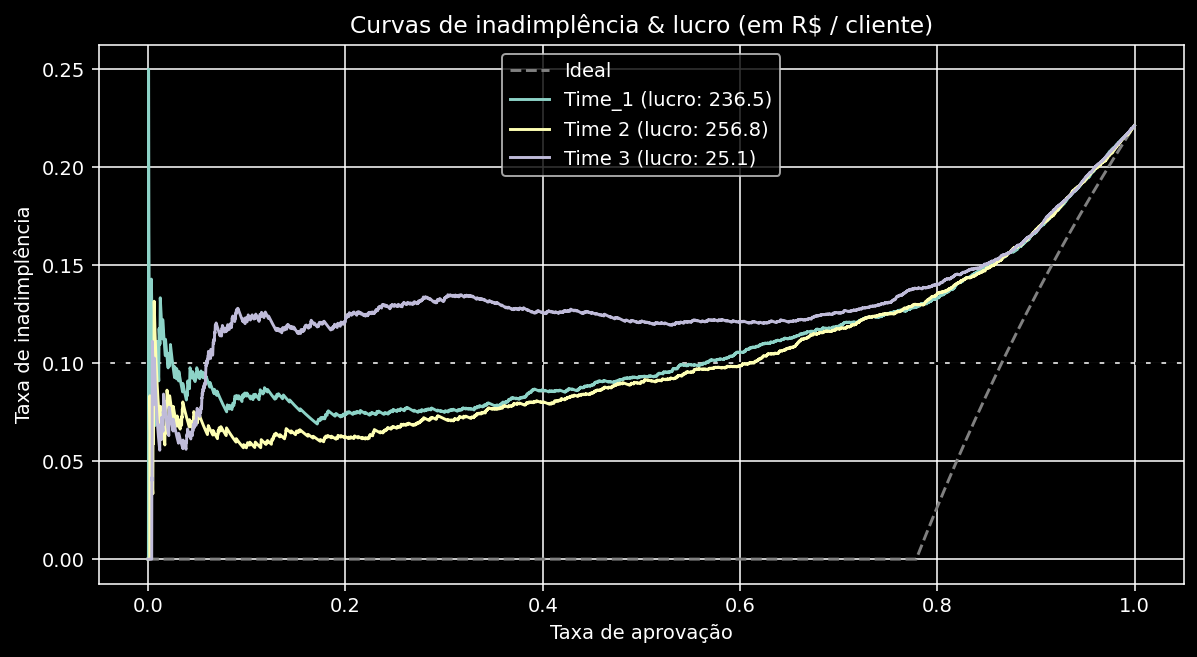

In [41]:
def build_curve(y_true, scores, burn=300):
    policy_df = pd.DataFrame({'score': scores, 'default': y_true}).sort_values('score', ascending=True).reset_index(drop=True)

    # construir taxa de inadimplência ao dividir a inadimplência total pelo total de indivíduos
    policy_df['taxa_inadimp'] = policy_df['default'].cumsum()/(policy_df.index + 1)
    policy_df['taxa_aprovacao'] = policy_df.index/len(policy_df)

    # remove the beginning of the curve
    aux = policy_df.iloc[burn:]
    best = aux.iloc[(aux['taxa_inadimp']-target_delinq).abs().argsort()].iloc[0]
    score = best.score
    taxa_aprov = best.taxa_aprovacao

    return policy_df, taxa_aprov


fig, ax = plt.subplots(figsize=(10,5))

plt.title(f"Curvas de inadimplência & lucro (em R$ / cliente)")
plt.xlabel("Taxa de aprovação")
plt.ylabel("Taxa de inadimplência")
plt.axhline(target_delinq, color='black', linestyle='--')
plt.grid()

ideal_df, _ = build_curve(y_test, y_test)
ax.plot(ideal_df['taxa_aprovacao'], ideal_df['taxa_inadimp'], label="Ideal", linestyle='--', color='gray')

for team, file in files:
    scores = pd.read_excel(folder + file, usecols=['Prediction'])['Prediction']
    
    policy_df, taxa_aprov = build_curve(y_test, scores)
    lucro = lucro_bom_pagador * taxa_aprov * (1-target_delinq) - preju_mau_pagador * taxa_aprov * target_delinq

    ax.plot(policy_df['taxa_aprovacao'], policy_df['taxa_inadimp'], label=f"{team} (lucro: {lucro:.1f})")

plt.legend()
plt.show()